In [ ]:
import pandas as pd
import numpy as np
import keras
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import minmax_scale
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
import tensorflow as tf
import math
import matplotlib.pyplot as plt

In [ ]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

No GPU, using /device:CPU:0.


In [ ]:
data_orig = pd.read_table('/content/140709A.dat',sep='\s+')
data_orig

,!Time,T_+ve,T_-ve,Flux,Fluxpos,Fluxneg
0,76.811954,0.410788,-0.453843,1.375409e-08,1.793554e-09,-34.904271
1,77.729344,0.493213,-0.506602,1.188395e-08,1.499063e-09,-30.158599
2,78.913008,0.764812,-0.690451,8.269363e-09,1.046179e-09,-20.979277
3,80.926885,1.447293,-1.249065,9.010007e-09,8.340343e-10,-16.226480
4,89.465000,0.208000,-0.303000,7.303974e-09,8.949279e-10,-18.728300
...,...,...,...,...,...,...
244,46747.439000,205.207000,-118.238000,3.920227e-12,9.076326e-13,-0.018988
245,47137.049000,206.727000,-184.404000,3.537427e-12,7.870700e-13,-0.016466
246,104572.689000,312.041000,-620.675000,9.737123e-13,2.581189e-13,-0.005400
247,110080.538000,863.599000,-690.927000,9.694036e-13,1.978736e-13,-0.004140


In [ ]:
from pandas import DataFrame as df

Y = df.to_numpy(data_orig)

In [ ]:
Y

array([[ 7.68119541e+01,  4.10787912e-01, -4.53843060e-01,
         1.37540867e-08,  1.79355395e-09, -3.49042713e+01],
       [ 7.77293441e+01,  4.93212928e-01, -5.06602119e-01,
         1.18839515e-08,  1.49906283e-09, -3.01585995e+01],
       [ 7.89130077e+01,  7.64812275e-01, -6.90450684e-01,
         8.26936315e-09,  1.04617856e-09, -2.09792772e+01],
       ...,
       [ 1.04572689e+05,  3.12041000e+02, -6.20675000e+02,
         9.73712290e-13,  2.58118948e-13, -5.39997800e-03],
       [ 1.10080538e+05,  8.63599000e+02, -6.90927000e+02,
         9.69403598e-13,  1.97873645e-13, -4.13961600e-03],
       [ 1.16046653e+05,  1.07764000e+03, -8.93097000e+02,
         9.09710958e-13,  1.78982750e-13, -3.74440900e-03]])

Text(0, 0.5, 'Flux (erg/cm^2/s)')

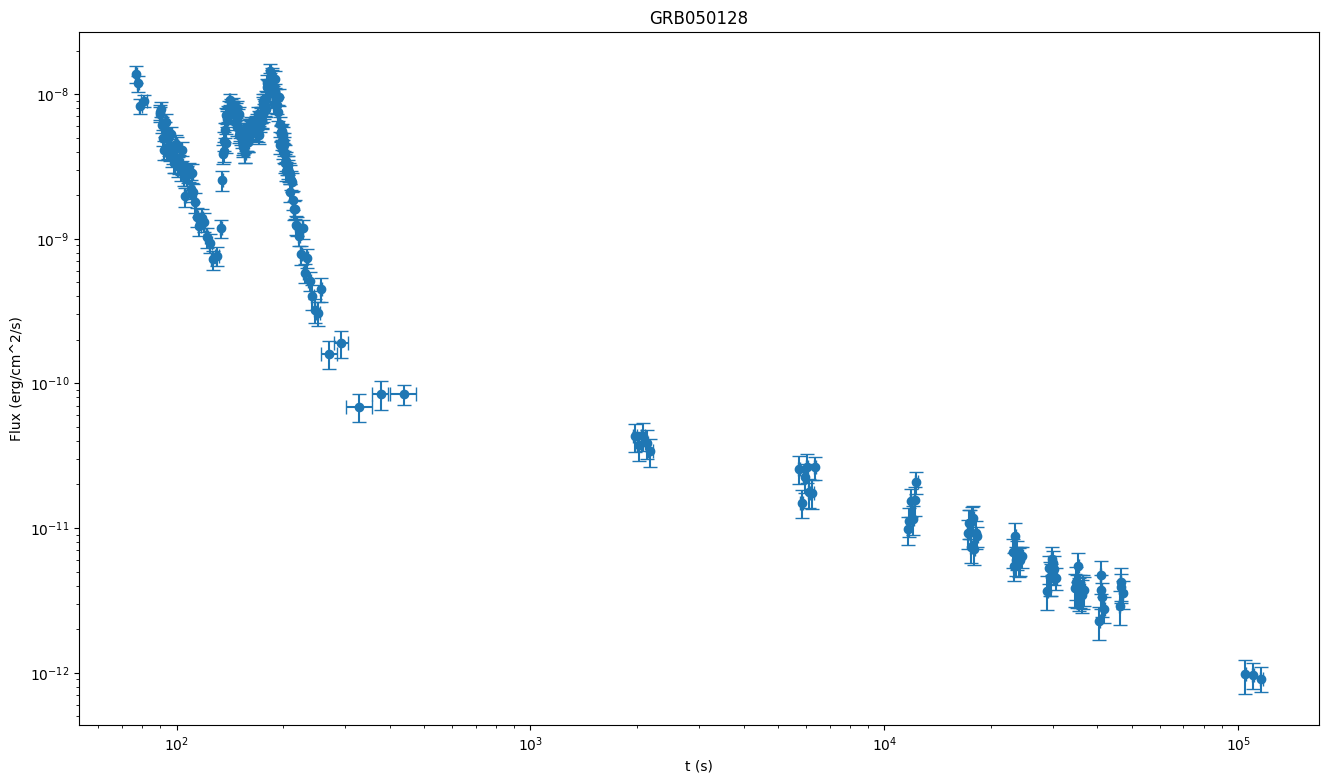

In [ ]:
plt.figure(figsize=(16,9))
plt.errorbar(Y[:,0], Y[:,3], linestyle='none', xerr=Y[:,1], yerr=Y[:,4], marker='o',capsize=5)
plt.loglog()
plt.title("GRB050128")
plt.xlabel("t (s)")
plt.ylabel("Flux (erg/cm^2/s)")

In [ ]:
after_burst = data_orig


In [ ]:
after_burst = after_burst.sort_values(by=['!Time'])

In [ ]:
after_burst

,!Time,T_+ve,T_-ve,Flux,Fluxpos,Fluxneg
0,76.811954,0.410788,-0.453843,1.375409e-08,1.793554e-09,-34.904271
1,77.729344,0.493213,-0.506602,1.188395e-08,1.499063e-09,-30.158599
2,78.913008,0.764812,-0.690451,8.269363e-09,1.046179e-09,-20.979277
3,80.926885,1.447293,-1.249065,9.010007e-09,8.340343e-10,-16.226480
4,89.465000,0.208000,-0.303000,7.303974e-09,8.949279e-10,-18.728300
...,...,...,...,...,...,...
244,46747.439000,205.207000,-118.238000,3.920227e-12,9.076326e-13,-0.018988
245,47137.049000,206.727000,-184.404000,3.537427e-12,7.870700e-13,-0.016466
246,104572.689000,312.041000,-620.675000,9.737123e-13,2.581189e-13,-0.005400
247,110080.538000,863.599000,-690.927000,9.694036e-13,1.978736e-13,-0.004140


In [ ]:
def create_batches(N,Ba_Sz,updated_after_burst):
  batches = []
  start = 0
  while(start < N) :
    if start + Ba_Sz <= N :
      after_burst_even = updated_after_burst.iloc[start:start + Ba_Sz]
      after_burst_even = after_burst_even.reset_index()
      batches.append(upsample_data(after_burst_even))
    else :
      after_burst_even = updated_after_burst.iloc[start:N]
      after_burst_even = after_burst_even.reset_index()
      batches.append(upsample_data(after_burst_even))
    start = start + Ba_Sz
  return batches

In [ ]:
def create_data(t,f):
  updated_after_burst = pd.DataFrame()
  updated_after_burst[t] = []
  updated_after_burst[f] = []
  for i in range(after_burst.shape[0]-1) :
    start_time = after_burst[t][i]
    end_time = after_burst[t][i+1]
    start_flux = after_burst[f][i]
    end_flux = after_burst[f][i+1]
    time_upd = (end_time - start_time) / 20
    flux_upd = (end_flux - start_flux) / 20
    for j in range(19):
      new_row = {t : start_time, f : start_flux}
      updated_after_burst = updated_after_burst.append(new_row,ignore_index = True)
      start_time = start_time + time_upd
      start_flux = start_flux + flux_upd
  return updated_after_burst


In [ ]:
def upsample_data(data):
  while(data.shape[0] < 20000) :
    data = data.append(data,ignore_index = True)
  return data

In [ ]:
def create_sequence(dataset):
    data_sequences = []
    for index in range(len(dataset)):
        data_sequences.append(dataset[index:index+1])
    return np.asarray(data_sequences)

In [ ]:
# Creating RNN Model Via Function Definition

def create_bilstm(units,X,Y):
    model = Sequential()

    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True),
              input_shape=(X.shape[0], X.shape[1])
              ))

    # Hidden layer
    model.add(Bidirectional(LSTM(units = units,return_sequences=True)))
    model.add(Bidirectional(LSTM(units = units,return_sequences=True)))
    model.add(Bidirectional(LSTM(units = units,return_sequences=True)))
    model.add(Bidirectional(LSTM(units = units)))
    layer = tf.keras.layers.Dense(1,activation = 'relu')
    model.add(layer)
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model


In [ ]:
units = 100

In [ ]:
# Training Of Model Via Function Definition

def fit_model(model,X,Y):
    early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 5)
    history = model.fit(X, Y, epochs = 75,
                        validation_split = 0.4,
                        batch_size =15, shuffle = True,
                        callbacks = [early_stop]
                        )
    return history

In [ ]:
def train_model(batches,B,t,f):
  # Training And Predicting For Each Batch

  preds = []

  for b in range(B) :
    batch = batches[b]
    X = batch[t]
    Y = batch[f]
    X = create_sequence(X)
    Y = Y[-X.shape[0]:]
    print('Model Training / Batch Number : {}'.format(b+1))
    model_b = create_bilstm(units,X,Y)
    histor = fit_model(model_b,X,Y)
    pr = model_b.predict(X)
    for x in pr :
      preds.append(x)
  return preds

In [ ]:
def time_seq(batches,B,t):
  time_predict = []
  for b in range(B) :
    for i in range(len(batches[b])):
      val = (batches[b][t][i])
      time_predict.append(val)
  return time_predict

**DATA PREPROCESSING**

In [ ]:
after_burst['!Time'] = (after_burst['!Time']) / 10**2

In [ ]:
b = after_burst['Flux'].min()
b

9.09710958e-13

In [ ]:
after_burst['Flux'] = np.log(after_burst['Flux'] / b) + 1

In [ ]:
a = after_burst['Fluxpos'].min()

In [ ]:
after_burst['Fluxpos'] = np.log(after_burst['Fluxpos'] / a) + 1

**FLUX TIME PREDICTION**

In [ ]:
flux_time_upd_data = create_data('!Time','Flux')

Streaming output truncated to the last 5000 lines.
<ipython-input-11-a01cad969440>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_after_burst = updated_after_burst.append(new_row,ignore_index = True)
<ipython-input-11-a01cad969440>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_after_burst = updated_after_burst.append(new_row,ignore_index = True)
<ipython-input-11-a01cad969440>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_after_burst = updated_after_burst.append(new_row,ignore_index = True)
<ipython-input-11-a01cad969440>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_after_burst = updated_a

In [ ]:
# Input for Number Of Data Points In Each Batch

Ba_Sz = int(input())

4000


In [ ]:
N = flux_time_upd_data.shape[0]

In [ ]:
batches_flux_time = create_batches(N,Ba_Sz,flux_time_upd_data)

<ipython-input-12-e353ce9f2ad7>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data,ignore_index = True)
<ipython-input-12-e353ce9f2ad7>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data,ignore_index = True)


In [ ]:
B = len(batches_flux_time)

In [ ]:
with tf.device(device_name):
  flux_preds = train_model(batches_flux_time,B,'!Time','Flux')

Model Training / Batch Number : 1
Epoch 1/75
1280/1280 [==============================] - 34s 17ms/step - loss: 2.2334 - val_loss: 0.3910
Epoch 2/75
1280/1280 [==============================] - 20s 15ms/step - loss: 0.3257 - val_loss: 0.2309
Epoch 3/75
1280/1280 [==============================] - 20s 15ms/step - loss: 0.1512 - val_loss: 0.0660
Epoch 4/75
1280/1280 [==============================] - 19s 15ms/step - loss: 0.0495 - val_loss: 0.0373
Epoch 5/75
1280/1280 [==============================] - 20s 15ms/step - loss: 0.0398 - val_loss: 0.0293
Epoch 6/75
1280/1280 [==============================] - 19s 15ms/step - loss: 0.0356 - val_loss: 0.0396
Epoch 7/75
1280/1280 [==============================] - 19s 15ms/step - loss: 0.0329 - val_loss: 0.0243
Epoch 8/75
1280/1280 [==============================] - 19s 15ms/step - loss: 0.0272 - val_loss: 0.0182
Epoch 9/75
1280/1280 [==============================] - 19s 15ms/step - loss: 0.0243 - val_loss: 0.0170
Epoch 10/75
1280/1280 [=======

**Prediction Of Error Bars**

In [ ]:
flux_time_error = create_data('T_+ve','Fluxpos')

<ipython-input-12-a01cad969440>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_after_burst = updated_after_burst.append(new_row,ignore_index = True)
<ipython-input-12-a01cad969440>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_after_burst = updated_after_burst.append(new_row,ignore_index = True)
<ipython-input-12-a01cad969440>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_after_burst = updated_after_burst.append(new_row,ignore_index = True)
<ipython-input-12-a01cad969440>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_after_burst = updated_after_burst.append(new_row,ignore_index = True)
<ipy

In [ ]:
Ba_Sz = int(input())

KeyboardInterrupt: ignored

In [ ]:
N = flux_time_error.shape[0]

In [ ]:
batches_flux_time_error = create_batches(N,Ba_Sz,flux_time_error)

<ipython-input-94-39259b215224>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data,ignore_index = True)


In [ ]:
B = len(batches_flux_time_error)

In [ ]:
with tf.device(device_name):
  flux_error_preds = train_model(batches_flux_time_error,B,'T_+ve','Fluxpos')

NameError: ignored

**Re Organising and Plotting of Data**

In [ ]:
batches_flux_time

[       index       !Time       Flux
 0          0    0.768120  10.623720
 1          1    0.768578  10.616412
 2          2    0.769037  10.609105
 3          3    0.769496  10.601798
 4          4    0.769954  10.594490
 ...      ...         ...        ...
 31995   3995  181.594022   3.302451
 31996   3996  181.681449   3.300241
 31997   3997  181.768875   3.298031
 31998   3998  181.856302   3.295821
 31999   3999  181.943728   3.293610
 
 [32000 rows x 3 columns],
        index        !Time      Flux
 0       4000   182.031155  3.291400
 1       4001   182.118581  3.289190
 2       4002   182.206008  3.286980
 3       4003   182.293434  3.284770
 4       4004   182.380861  3.282560
 ...      ...          ...       ...
 22779   4707  1142.568185  1.019066
 22780   4708  1145.551243  1.015889
 22781   4709  1148.534300  1.012711
 22782   4710  1151.517358  1.009533
 22783   4711  1154.500415  1.006355
 
 [22784 rows x 3 columns]]

In [ ]:
fl = []
ti = []
for batch in batches_flux_time :
  for f in batch['Flux']:
    fl.append(f)
  for t in batch['!Time']:
    ti.append(t)

In [ ]:
Flux_std = np.std(fl)
Time_std = np.std(ti)

In [ ]:
Flux_std

3.4315388970668175

In [ ]:
Time_std

223.2889529961134

In [ ]:
time_predict = time_seq(batches_flux_time,len(batches_flux_time),'!Time')

In [ ]:
time_predict = np.array(time_predict)
X_new , idx = np.unique(time_predict,return_index = True)
Y_new = [flux_preds[i] for i in idx]

In [ ]:
X_new.shape


(4712,)

In [ ]:
Y_new = np.array(Y_new)

In [ ]:
Y_new.shape

(4712, 1)

Text(0.5, 1.0, 'Flux vs Time Prediction for Bump Flare GRB 140709A')

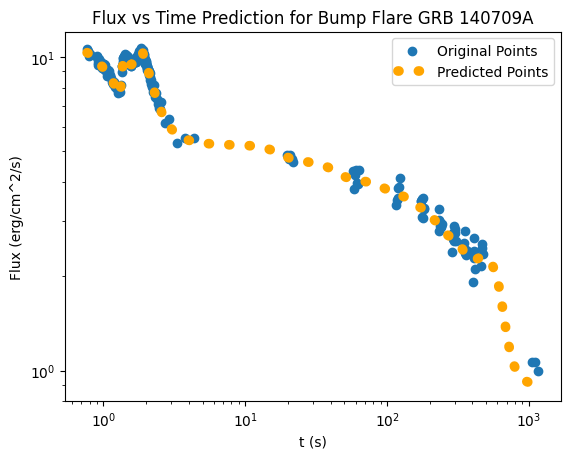

In [ ]:
plt.scatter(after_burst['!Time'],after_burst['Flux'])
plt.plot(X_new,Y_new[:,0],color='orange',  linestyle = (0,(0.1,2)),
    dash_capstyle = 'round', linewidth=7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("t (s)")
plt.ylabel("Flux (erg/cm^2/s)")
plt.legend(['Original Points','Predicted Points'])
plt.title("Flux vs Time Prediction for Bump Flare GRB 140709A")

In [ ]:
Y_new_std = np.std(Y_new)
Y_new_std

2.7390242

In [ ]:
X = pd.DataFrame()
X['!Time'] = X_new

X['Flux'] = Y_new

In [ ]:
X['Flux_err'] = flux_p

In [ ]:
X = df.to_numpy(X)

In [ ]:
Y_temp = Y

In [ ]:
Y_temp

array([[ 1.25025000e+02,  1.64670000e+01, -2.86640000e+01,
         1.12474958e-10,  2.53451957e-11, -7.54321300e-01],
       [ 1.60327000e+02,  2.12830000e+01, -1.88340000e+01,
         1.31357083e-10,  2.88228864e-11, -8.57824000e-01],
       [ 2.01584000e+02,  1.76350000e+01, -1.99740000e+01,
         1.33331386e-10,  2.98712736e-11, -8.89026000e-01],
       [ 2.61564000e+02,  2.53520000e+01, -4.23450000e+01,
         9.21598608e-11,  1.85365723e-11, -5.51683700e-01],
       [ 2.96359000e+02,  5.60100000e+00, -9.44200000e+00,
         7.21274400e-10,  1.10388432e-10, -3.28537000e+00],
       [ 3.07672000e+02,  4.31800000e+00, -5.71200000e+00,
         9.29890416e-10,  1.53298118e-10, -4.56244400e+00],
       [ 3.15517000e+02,  3.99500000e+00, -3.52700000e+00,
         1.10340955e-09,  1.92602928e-10, -5.73223000e+00],
       [ 3.24179000e+02,  5.36100000e+00, -4.66800000e+00,
         7.58196432e-10,  1.38664210e-10, -4.12691100e+00],
       [ 3.34220000e+02,  7.85700000e+00, -4.680

In [ ]:
Y_temp[:,0] = Y_temp[:,0] / 100

In [ ]:
Y_temp[:,3] = np.log(Y_temp[:,3] / np.min(Y_temp[:,3])) + 1
Y_temp[:,4] = np.log(Y_temp[:,4] / np.min(Y_temp[:,4])) + 1

In [ ]:
Y_temp

array([[ 1.25025000e+00,  1.64670000e+01, -2.86640000e+01,
         7.30124290e+00,  6.90750019e+00, -7.54321300e-01],
       [ 1.60327000e+00,  2.12830000e+01, -1.88340000e+01,
         7.45643173e+00,  7.03608073e+00, -8.57824000e-01],
       [ 2.01584000e+00,  1.76350000e+01, -1.99740000e+01,
         7.47134994e+00,  7.07180827e+00, -8.89026000e-01],
       [ 2.61564000e+00,  2.53520000e+01, -4.23450000e+01,
         7.10203698e+00,  6.59465666e+00, -5.51683700e-01],
       [ 2.96359000e+00,  5.60100000e+00, -9.44200000e+00,
         9.15953194e+00,  8.37891634e+00, -3.28537000e+00],
       [ 3.07672000e+00,  4.31800000e+00, -5.71200000e+00,
         9.41357904e+00,  8.70729551e+00, -4.56244400e+00],
       [ 3.15517000e+00,  3.99500000e+00, -3.52700000e+00,
         9.58467255e+00,  8.93554170e+00, -5.73223000e+00],
       [ 3.24179000e+00,  5.36100000e+00, -4.66800000e+00,
         9.20945479e+00,  8.60696625e+00, -4.12691100e+00],
       [ 3.34220000e+00,  7.85700000e+00, -4.680

In [ ]:
X[:,1] = (2.062817568e-13) * np.exp(X[:,1]-1)
X[:,2] = (2.062817568e-13) * np.exp(X[:,2]-1)
X[:,0] = X[:,0] * 10**2


In [ ]:
for i in range(len(X)):
  X[i][2] = np.random.uniform(1.0,1.000025)*X[i][2]

Text(0, 0.5, 'Flux (erg/cm^2/s)')

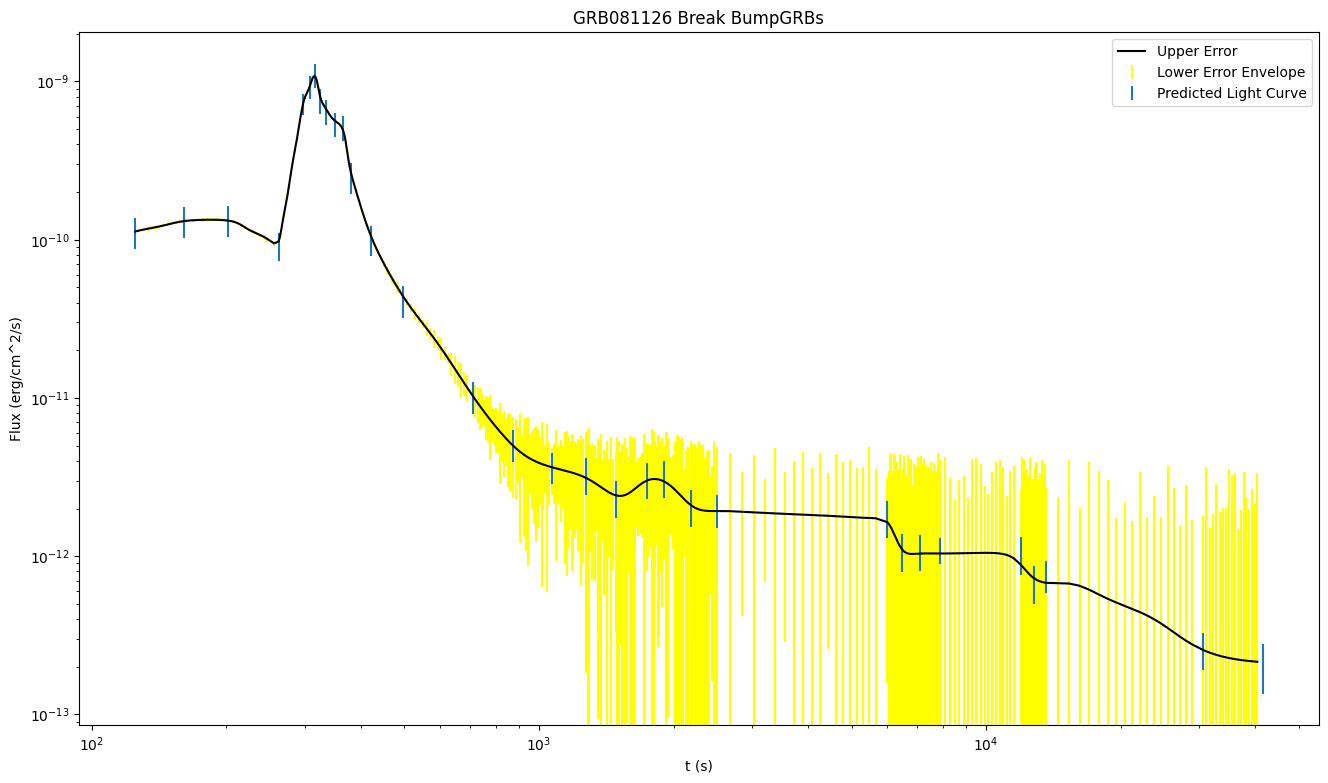

In [ ]:
plt.figure(figsize=(16,9))
plt.errorbar(X[:,0], X[:,1], linestyle='none', yerr=X[:,2],color='yellow')
plt.errorbar(Y[:,0], Y[:,3], linestyle='none', yerr=Y[:,4])
# plt.plot(X[:,0],X[:,1]+X[:,2],color='red')
# plt.plot(X[:,0],X[:,1]-X[:,2],color='red')
plt.plot(X[:,0],X[:,1],color = 'black')
plt.legend(['Upper Error','Lower Error Envelope','Predicted Light Curve','Predicted Points','Actual Points'])
plt.title("GRB081126 Break BumpGRBs")
plt.loglog()
plt.xlabel("t (s)")
plt.ylabel("Flux (erg/cm^2/s)")

In [ ]:
T_err = np.zeros(len(X_new)) * Time_std
T_err.shape

(589,)

In [ ]:
F_err = np.ones(len(X_new)) * Flux_std
F_err.shape

(589,)

In [ ]:

X_new.shape

(589,)

In [ ]:
Y_new = np.array(Y_new)
Y_new = Y_new.reshape(len(Y_new))
Y_new.shape

(589,)

In [ ]:
df_new = pd.DataFrame()
df_new['!Time'] = X_new
df_new['Flux'] = Y_new
df_new['T_+ve'] = T_err
df_new['Fluxpos'] = F_err
for i in range(len(df_new)):
  df_new['Flux'][i] = df_new['Flux'][i]- 1
  df_new['Fluxpos'][i] = df_new['Fluxpos'][i] - 1
for i in range(len(df_new)):
  df_new['!Time'][i] = df_new['!Time'][i] * 100
  df_new['Flux'][i] = b * np.exp(df_new['Flux'][i])
  df_new['Fluxpos'][i] = a * np.exp(df_new['Fluxpos'][i])
df_new = df_new.to_numpy()

<ipython-input-46-163ecc363c1c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Flux'][i] = df_new['Flux'][i]- 1
<ipython-input-46-163ecc363c1c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Fluxpos'][i] = df_new['Fluxpos'][i] - 1
<ipython-input-46-163ecc363c1c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['!Time'][i] = df_new['!Time'][i] * 100
<ipython-input-46-163ecc363c1c>:11: SettingWithCopyWarning: 

Text(0, 0.5, 'Flux (erg/cm^2/s)')

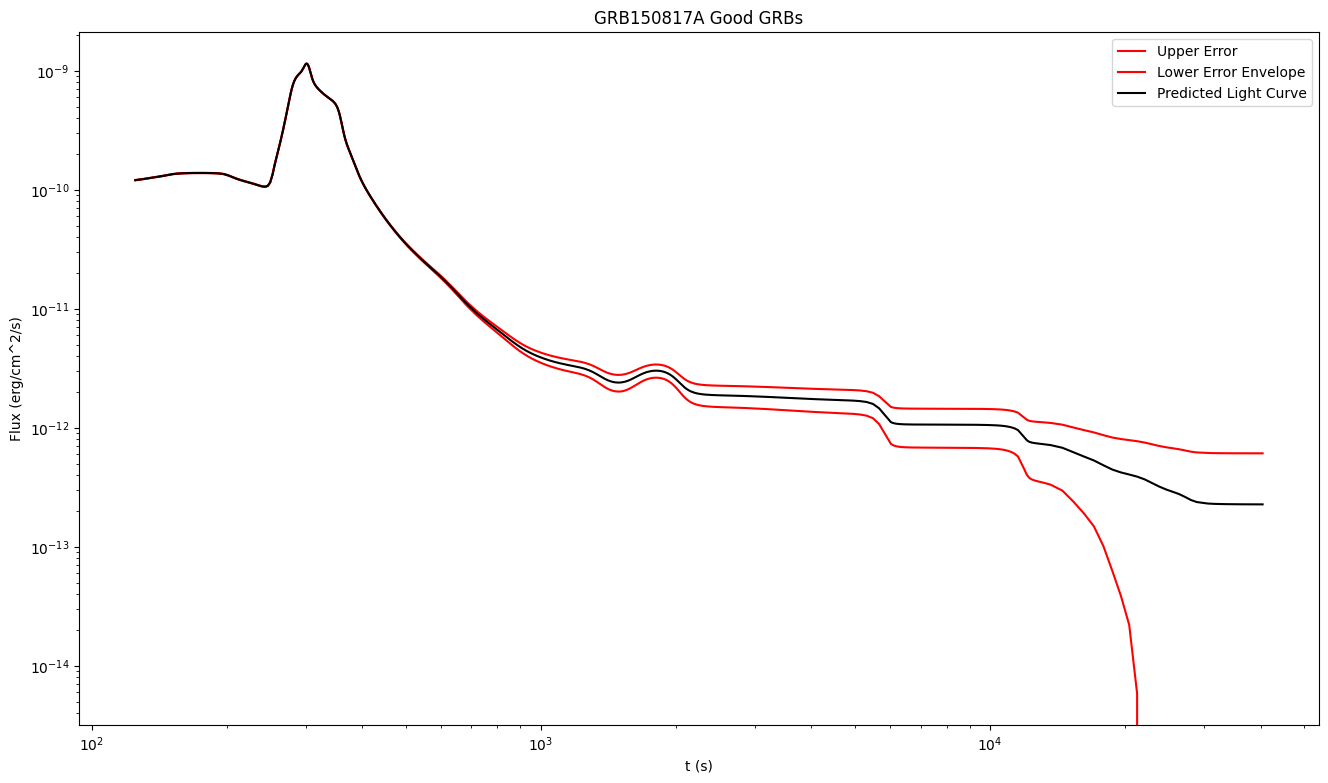

In [ ]:
plt.figure(figsize=(16,9))
plt.errorbar(df_new[:,0], df_new[:,1], linestyle='none', yerr=df_new[:,3],color='yellow', capsize =0.5)
plt.errorbar(Y[:,0], Y[:,3], linestyle='none', xerr=Y[:,1], yerr=Y[:,4])
plt.plot(df_new[:,0],df_new[:,3]+df_new[:,1],color='red')
plt.plot(df_new[:,0],df_new[:,1]- df_new[:,3],color='red')
plt.plot(df_new[:,0],df_new[:,1],color = 'black')
plt.legend(['Upper Error','Lower Error Envelope','Predicted Light Curve','Predicted Points','Actual Points'])
plt.loglog()
plt.title("GRB150817A Good GRBs")
plt.xlabel("t (s)")
plt.ylabel("Flux (erg/cm^2/s)")